In [5]:
import numpy as np
import pandas as pd
import glob
from scipy import ndimage
from astropy.table import Table
from astropy import wcs
from collections import OrderedDict as odict
from astropy.io import fits
from astropy.coordinates import SkyCoord
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.size']=14
fs = 14

%matplotlib notebook

### Make the discovery image
Note that I use data from Apr 10, not the first detection epoch

In [2]:
def get_frame(fp, hdnum, ra, dec, r_psf, lrflip=False, udflip=False):
    hd = fits.open(fp)[hdnum].header
    dt = fits.open(fp)[hdnum].data
    w = wcs.WCS(hd)
    world =  np.array([[ra, dec]], np.float_)
    pixcrd = w.wcs_world2pix(world, 0)
    pixX = pixcrd[0, 0]
    pixY = pixcrd[0, 1]
    
    pixXint = int(np.rint(pixX))
    pixYint = int(np.rint(pixY))
    
    scr_fn_1 = dt[pixYint - r_psf - 1 : pixYint + r_psf + 2, 
                  pixXint - r_psf - 1 : pixXint + r_psf + 2]
    xoff_tobe = pixX - pixXint
    yoff_tobe = pixY - pixYint
    scr_fn_ = ndimage.shift(scr_fn_1, [-yoff_tobe, -xoff_tobe], order=3, 
                            mode='reflect', cval=0.0, prefilter=True)
    scr_fn = scr_fn_[1:-1, 1:-1] 
    
    if lrflip:
        scr_fn = np.fliplr(scr_fn)
        
    if udflip:
        scr_fn = np.flipud(scr_fn)
    return scr_fn

In [3]:
def regularize_ax(ax):
    ax.set_xticklabels([])
    ax.set_yticklabels([]) 
    ax.set_xticks([])
    ax.set_yticks([])
    
def add_northeast(ax3, r_psf, length, edge = 5, tol=2, linecolor = "r", textcolor = "k"):
    """
    r_psf: half width of the image (this is a misnomer)
    """
    ax3.plot([2*r_psf-edge, 2*r_psf-edge], [0+edge, length+edge], '-', color = linecolor)
    ax3.plot([2*r_psf-length-edge, 2*r_psf-edge], [0+edge, 0+edge], '-', color = linecolor)
    ax3.text(2*r_psf-edge - tol, length+edge + tol, 'N', fontsize=fs, color = textcolor)
    ax3.text(2*r_psf-length-edge - tol*2, edge - tol, 'E', fontsize=fs, color = textcolor)

In [8]:
def make_discovery_image():
    ra, dec = np.loadtxt('../data/detection_pos/coo_kowalski.reg')
    # science image
    fp1 = "../data/images/image_sci/ztf_20190410408137_000763_zg_c14_o_q3_sciimg.fits"
    # reference image
    fp2 = "../data/images/image_ref/g/ztf_000763_zg_c14_q3_refimg.fits"
    # difference image
    fp3 = "../data/images/image_diff/ztf_20190410408137_000763_zg_c14_o_q3_scimrefdiffimg.fits.fz"
    r_psf = 45
    scr_fn1 = get_frame(fp1, 0, ra, dec, r_psf, udflip=True)
    scr_fn2 = get_frame(fp2, 0, ra, dec, r_psf, lrflip=True, udflip=True)
    scr_fn3 = get_frame(fp3, 1, ra, dec, r_psf, udflip=True)
    
    
    plt.figure(figsize=(7.5, 2.7))
    plt.set_cmap('gray_r')
    ax1 = plt.subplot(131)
    ax2 = plt.subplot(132)
    ax3 = plt.subplot(133)
    ax1.imshow(scr_fn1, origin='lower')
    ax2.imshow(scr_fn2, origin='lower')
    ax3.imshow(scr_fn3, origin='lower')
    
    ax1.set_title("New", fontsize=fs)
    ax2.set_title("Ref", fontsize=fs)
    ax3.set_title("Sub", fontsize=fs)
    regularize_ax(ax1)
    regularize_ax(ax2)
    regularize_ax(ax3)
    
    xstart = 7
    xend = xstart+20/1.012
    yline = 12
    ax1.plot([xstart, xend], [yline, yline], '-', color = 'r', linewidth = 1.5)
    ax1.plot([xstart, xstart], [yline-1, yline+1], '-', color = 'r', linewidth = 1.5)
    ax1.plot([xend, xend], [yline-1, yline+1], '-', color = 'r', linewidth = 1.5)
    ax1.text(xstart+3, yline+3, "20''", color = 'r', fontsize = fs-2)
    ax1.text(xstart-4, yline-9, "8.6 kpc", color = 'r', fontsize = fs-2)
    
    add_northeast(ax3, r_psf, length=15, edge=5, tol=3)
    
    plt.tight_layout(w_pad=0, h_pad = -0.2, rect = [0, 0, 1, 0.97])
    plt.savefig("../paper/figures/detection.pdf")

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


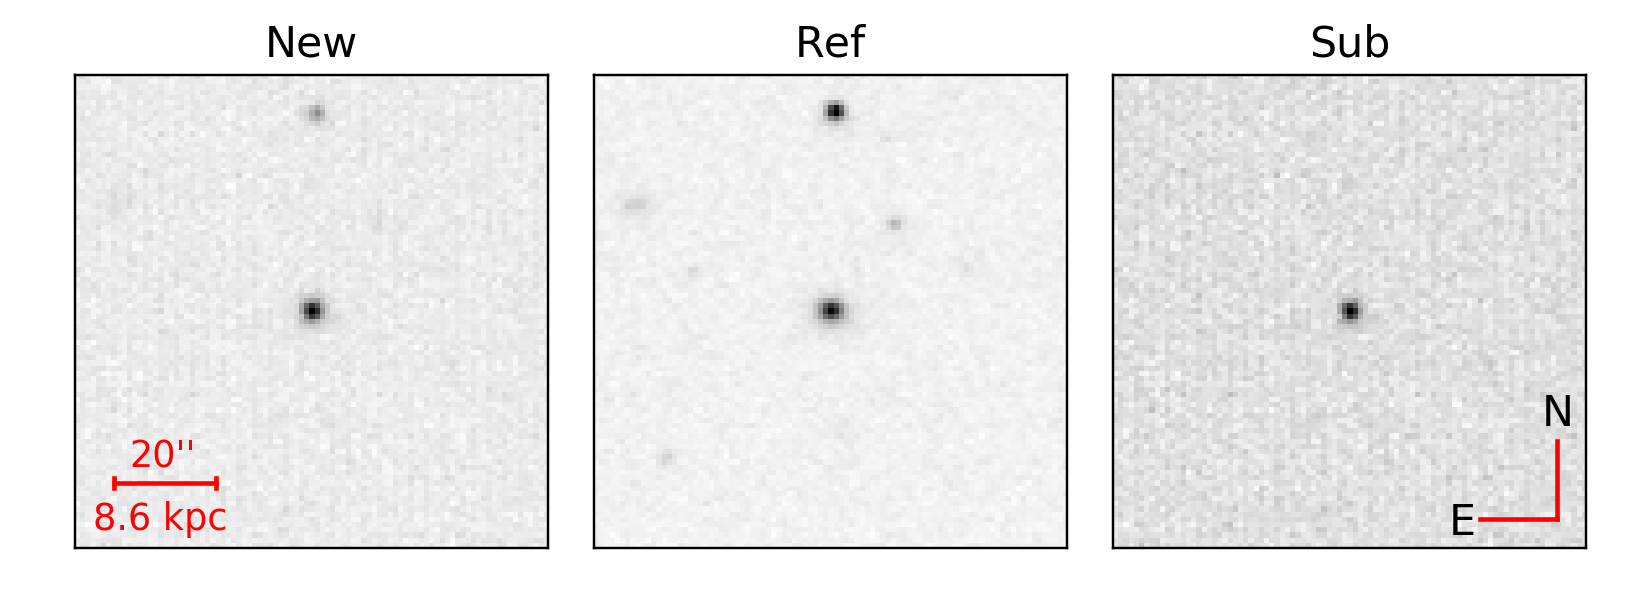

In [9]:
make_discovery_image()

### Mark the Transient position. Using Legacy Survey Image

In [10]:
from astropy.visualization import make_lupton_rgb
from astropy.wcs import WCS

In [11]:
files = glob.glob("../data/images/legacy_survey/*.fits.fz")
print (files[0])
print (files[1])
print (files[2])

../data/images/legacy_survey/legacysurvey-2643p505-image-g.fits.fz
../data/images/legacy_survey/legacysurvey-2643p505-image-r.fits.fz
../data/images/legacy_survey/legacysurvey-2643p505-image-z.fits.fz


In [12]:
hdug = fits.open(files[0])[1]
hdur = fits.open(files[1])[1]
hduz = fits.open(files[2])[1]

From Zou et al. (2017): pixel scale is about 0.454 arcsec per pixel

In [13]:
wcs = WCS(hdug.header)

In [14]:
ra, dec = np.loadtxt("../data/detection_pos/coo_kowalski.reg")

In [15]:
x, y = wcs.wcs_world2pix(ra, dec, 0)
xint = int(x)
yint = int(y)
print (x, y)
hw = 50

2945.88576923941 2457.6655408396973


In [16]:
xpos = x - (xint-hw)
ypos = y - (yint-hw)

In [17]:
image_r = hdur.data[yint-hw:yint+hw, xint-hw:xint+hw]
image_g = hdug.data[yint-hw:yint+hw, xint-hw:xint+hw]
image_z = hduz.data[yint-hw:yint+hw, xint-hw:xint+hw]

In [18]:
minimum = 0.001
image = make_lupton_rgb(image_z/6, image_r/3, image_g, stretch=0.03, Q=5, minimum = [minimum/6, minimum/3, minimum])

In [19]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.275)
dA_Mpc = cosmo.angular_diameter_distance(z = 0.0213).value # in Mpc
dA_Mpc * 5 / (60*60) / 180 * np.pi * 1e+3 # in kpc

2.155616634998802

In [20]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.275)
dA_Mpc = cosmo.angular_diameter_distance(z = 0.0213).value # in Mpc
dA_Mpc * 20 / (60*60) / 180 * np.pi * 1e+3 # in kpc

8.622466539995209

<IPython.core.display.Javascript object>


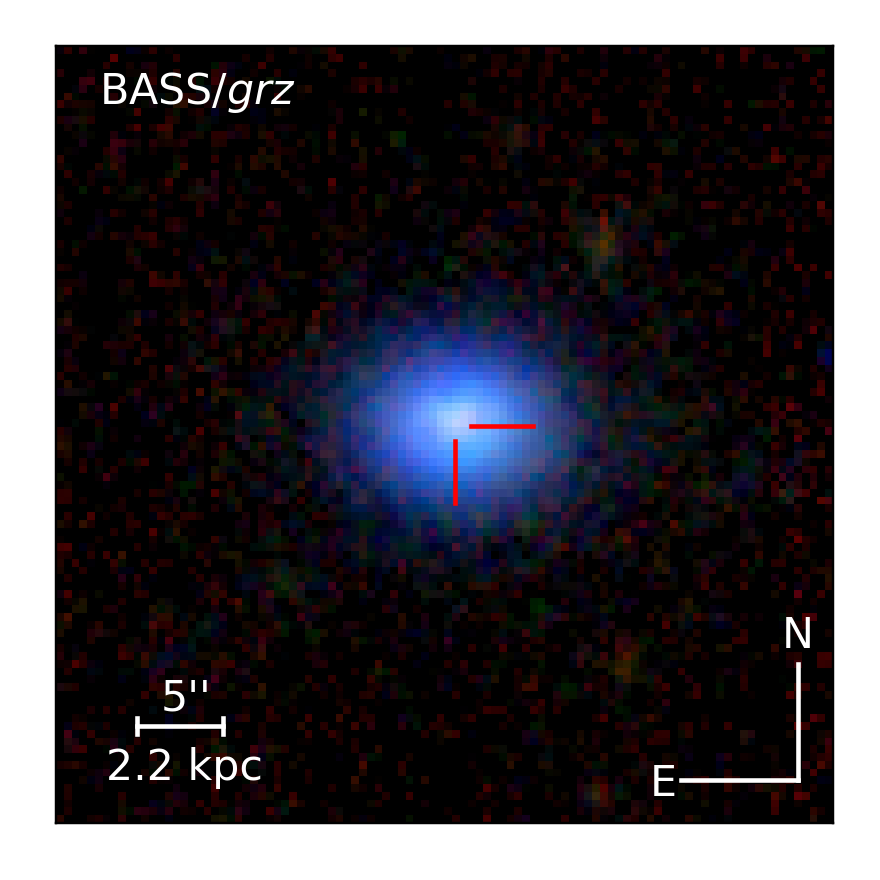

In [31]:
plt.figure(figsize = (4., 4.))
ax = plt.subplot(111)
ax.imshow(image, origin = "lower")
ax.set_xticks([])
ax.set_yticks([])
ax.plot([xpos, xpos], [ypos-2, ypos-10], 'r-', linewidth = 1.5)
ax.plot([xpos+2, xpos+10], [ypos, ypos], 'r-', linewidth = 1.5)
xstart = 10
xend = xstart+5/0.454
yline = 12
ax.plot([xstart, xend], [yline, yline], '-', color = 'white', linewidth = 1.5)
ax.plot([xstart, xstart], [yline-1, yline+1], '-', color = 'white', linewidth = 1.5)
ax.plot([xend, xend], [yline-1, yline+1], '-', color = 'white', linewidth = 1.5)
ax.text(5, hw*2-8, 'BASS/$grz$', color = 'white')
ax.text(xstart+3, yline+2, "5''", color = 'white')
ax.text(xstart-4, yline-7, "2.2 kpc", color = 'white')
add_northeast(ax, hw, 15, edge = 5, tol=2, linecolor = "white", textcolor = "white")
plt.tight_layout()
# plt.savefig("../paper/figures/offset.pdf")

### Galaxy position:

In [280]:
dA_Mpc * sep2g / (60*60) / 180 * np.pi * 1e+3 # in kpc 

0.06169122128876245

In [101]:
from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize, LogStretch)

In [156]:
ra_hst, dec_hst = np.loadtxt("../data/detection_pos/coo_hst.reg")
dec_hst_ = dec_hst+0.001
ra_hst_ = ra_hst+0.001

In [159]:
hdu2 = fits.open("../data/hst/MAST_2020-03-01T1848/HST/idyq7b030/idyq7b030_drz.fits")[1]
wcs2 = WCS(hdu2.header)
x2, y2 = wcs2.wcs_world2pix(ra_hst, dec_hst, 0)
_, y2_ = wcs2.wcs_world2pix(ra_hst, dec_hst_, 0)
x2_, _ = wcs2.wcs_world2pix(ra_hst_, dec_hst, 0)
xint2 = int(x2)
yint2 = int(y2)
print (x2, y2)
hw = 50
xpos = x2 - (xint2-hw)
ypos = y2 - (yint2-hw)
ypos_ = y2_ - (yint2-hw)
xpos_ = x2_ - (xint2-hw)

565.172529008706 536.2189635528534


In [165]:
pixscale2 = fits.open("../data/hst/MAST_2020-03-01T1848/HST/idyq7b030/idyq7b030_drz.fits")[0].header["D001SCAL"] # Drizzle, pixel size (arcsec) of output image
print (pixscale2)


0.03962000086903572


In [153]:
norm = ImageNormalize(image, interval=MinMaxInterval(),
                      stretch=LogStretch())

In [154]:
dA_Mpc * 0.5 / (60*60) / 180 * np.pi * 1e+3 # in kpc

0.2155616634998802

<IPython.core.display.Javascript object>


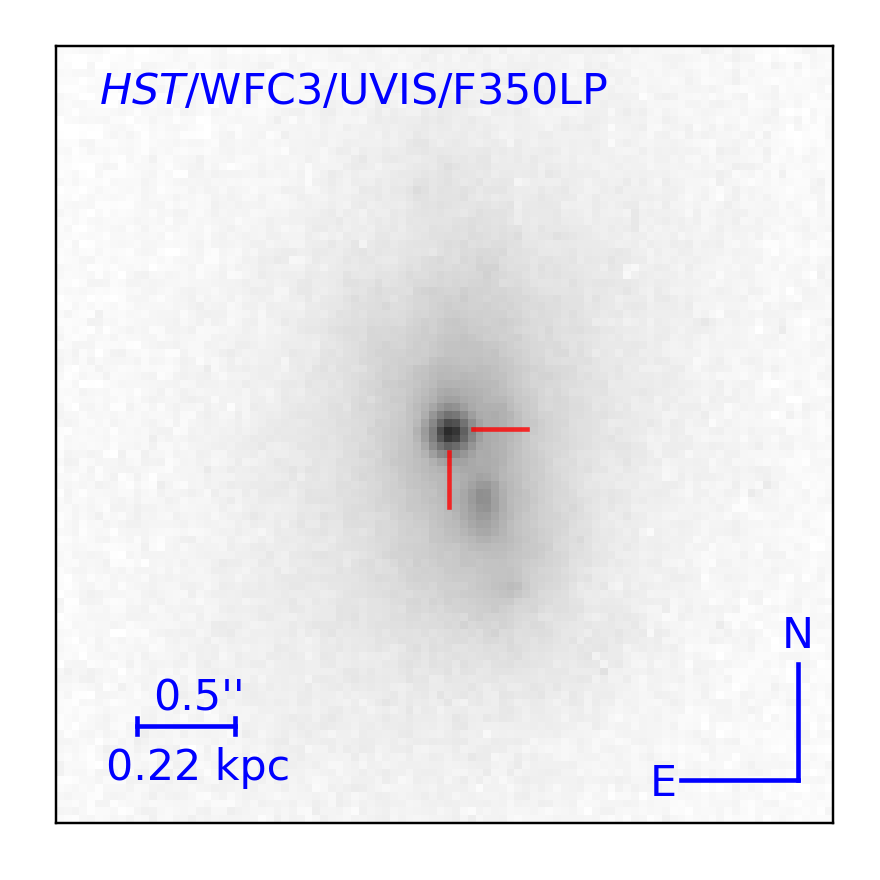

In [172]:
plt.figure(figsize = (4., 4.))
ax = plt.subplot(111)
ax.imshow(image2, origin = "lower", norm=norm)
ax.set_xticks([])
ax.set_yticks([])
ax.plot([xpos, xpos], [ypos-3, ypos-10], 'r-', linewidth = 1.5, alpha = 0.8)
ax.plot([xpos+3, xpos+10], [ypos, ypos], 'r-', linewidth = 1.5, alpha = 0.8)
xstart = 10
xend = xstart+0.5/pixscale2
yline = 12
ax.plot([xstart, xend], [yline, yline], '-', color = 'b', linewidth = 1.5)
ax.plot([xstart, xstart], [yline-1, yline+1], '-', color = 'b', linewidth = 1.5)
ax.plot([xend, xend], [yline-1, yline+1], '-', color = 'b', linewidth = 1.5)
ax.text(xstart+2, yline+2, "0.5''", color = 'b')
ax.text(xstart-4, yline-7, "0.22 kpc", color = 'b')
ax.text(5, hw*2-8, '$HST$/WFC3/UVIS/F350LP', color = 'b')
#ax.plot([xpos, xpos], [ypos, ypos_], 'm-')
#ax.plot([xpos, xpos_], [ypos, ypos], 'm-')
add_northeast(ax, hw, 15, edge = 5, tol=2, linecolor = "b", textcolor = "b")
plt.tight_layout()
plt.savefig("../paper/figures/offset.pdf")